In [1]:
%load_ext autoreload
%autoreload 2

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({"font.size": 16})

<IPython.core.display.Javascript object>

In [3]:
import numpy as np

<IPython.core.display.Javascript object>

In [4]:
import phenom

<IPython.core.display.Javascript object>

In [5]:
from scrinet.interfaces import lalutils

<IPython.core.display.Javascript object>

In [6]:
import scrinet.analysis

<IPython.core.display.Javascript object>

In [7]:
from scrinet.analysis.timeseries import TimeSeries
from scrinet.analysis.frequencyseries import FrequencySeries
from scrinet.analysis import matchedfilter

<IPython.core.display.Javascript object>

In [8]:
import tensorflow as tf

<IPython.core.display.Javascript object>

# generate waveforms

In [9]:
# distance=1e6*lalutils.lal.PC_SI
distance = 1

<IPython.core.display.Javascript object>

In [10]:
p = lalutils.gen_td_wf_params(m1=32.5, m2=32.5, f_min=20, distance=distance)
t, amp, phase = lalutils.gen_td_wf(p, t_min=None, t_max=100)
h = amp * np.exp(-1.0j * phase)
hp = np.real(h)
hc = np.imag(h)
# convert time from M to s
t_s = phenom.MtoS(t, p["m1"] + p["m2"])
dt = t_s[1] - t_s[0]

signal = TimeSeries(hp, t_s[1] - t_s[0], epoch=t_s[0])

<IPython.core.display.Javascript object>

Text(0.5, 0, 't/s')

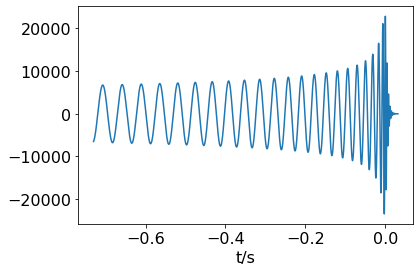

<IPython.core.display.Javascript object>

In [11]:
plt.figure()
plt.plot(signal.sample_times, signal.data)
plt.xlabel("t/s")

In [12]:
templates = []
M_arr = np.linspace(55, 65, 10)
for M in M_arr:
    m1, m2 = phenom.m1_m2_M_q(M, q=1)
    p = lalutils.gen_td_wf_params(m1=m1, m2=m2, f_min=20, distance=distance)
    t, amp, phase = lalutils.gen_td_wf(p, t_min=None, t_max=100)
    h = amp * np.exp(-1.0j * phase)
    hp = np.real(h)
    hc = np.imag(h)
    # convert time from M to s
    t_s = phenom.MtoS(t, p["m1"] + p["m2"])
    dt = t_s[1] - t_s[0]

    template = TimeSeries(hp, dt, epoch=t_s[0])
    templates.append(template)

<IPython.core.display.Javascript object>

# compute match

In [13]:
matches = []
for i, template in enumerate(templates):
    print(f"working: {i}")
    np.testing.assert_almost_equal(
        signal.delta_t.numpy(),
        template.delta_t.numpy(),
        err_msg=f"{signal.delta_t.numpy()}, {template.delta_t.numpy()}",
    )
    delta_t = signal.delta_t

    # need to zero pad to same length
    sig_shape = signal.data.shape[0]
    temp_shape = template.data.shape[0]
    new_len = np.max([sig_shape, temp_shape])

    arr_to_append = np.zeros(new_len - sig_shape)
    new_sig = TimeSeries(
        np.append(signal.data.numpy(), arr_to_append),
        delta_t=delta_t,
        epoch=signal._epoch,
    )

    arr_to_append = np.zeros(new_len - temp_shape)
    new_temp = TimeSeries(
        np.append(template.data.numpy(), arr_to_append),
        delta_t=delta_t,
        epoch=template._epoch,
    )

    m = matchedfilter.match(new_sig, new_temp)
    matches.append(m)
    

working: 0
working: 1
working: 2
working: 3
working: 4
working: 5
working: 6
working: 7
working: 8
working: 9


<IPython.core.display.Javascript object>

In [14]:
matches_arr = np.array([m.numpy() for m in matches])

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'match vs total mass')

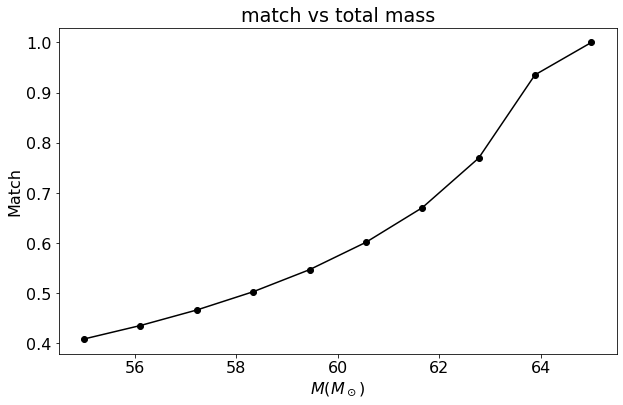

<IPython.core.display.Javascript object>

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(M_arr, matches_arr, "k-o")
plt.xlabel(r"$M (M_\odot)$")
plt.ylabel("Match")
plt.title("match vs total mass")

# using batch

In [16]:
from scrinet.analysis.timeseries_batch import TimeSeries as TimeSeries_batch
from scrinet.analysis.frequencyseries_batch import (
    FrequencySeries as FrequencySeries_batch,
)
from scrinet.analysis import matchedfilter_batch

<IPython.core.display.Javascript object>

In [17]:
# using *_batch functions we store all the waveforms in a large tensor
# we first need to figure out the size of the tensor.
# the tensor will be called `hps`
# hps.shape = (num_waveforms, max_len)
# num_waveforms: is the number of waveforms
# max_len: is the length of the longest waveform:
#   both in the set and of the signal waveform.
#   we will resize (zero pad) all other waveforms to this length.

num_waveforms = len(templates)

lens = [template.data.shape[0] for template in templates]
max_len = tf.math.reduce_max(lens).numpy()
print(f"template max length: {max_len}")

# get signal length
sig_len = signal.data.shape[0]
print(f"signal length: {sig_len}")

len_diff = np.abs(sig_len - max_len)

print(f"len_diff: {len_diff}")

if sig_len > max_len:
    # resize templates
    final_max_len = sig_len
elif max_len > sig_len:
    # resize the signal
    final_max_len = max_len

print(f"final max len: {final_max_len}")

hps = np.zeros((num_waveforms, final_max_len))

template max length: 4197
signal length: 3122
len_diff: 1075
final max len: 4197


<IPython.core.display.Javascript object>

In [18]:
# resize signal
new_signal_data = np.zeros((1, final_max_len))
sig_len_to_append = len_diff
arr_to_append = np.zeros(sig_len_to_append)
new_signal_data[0] = np.append(signal.data.numpy(), arr_to_append)
new_sig_batch_ts = TimeSeries_batch(new_signal_data, delta_t=signal.delta_t, epoch=signal._epoch)


for i, template in enumerate(templates):
    print(f"working: {i}")
    np.testing.assert_almost_equal(signal.delta_t.numpy(),
                                   template.delta_t.numpy(),
                                   err_msg=f"{signal.delta_t.numpy()}, {template.delta_t.numpy()}")
    delta_t = signal.delta_t
    
    # need to zero pad to same length
    
    temp_shape = template.data.shape[0]
    new_len = np.abs(final_max_len - temp_shape)
    
    arr_to_append = np.zeros(new_len)
    
    
    hps[i] = np.append(template.data.numpy(), arr_to_append)
    
    



##########
#####
#####
##########
#####
#####
##########
#####
#####
# make epoch a tensor in TimeSeries_batch



working: 0
working: 1
working: 2
working: 3
working: 4
working: 5
working: 6
working: 7
working: 8
working: 9


<IPython.core.display.Javascript object>

In [82]:
epochs = [template._epoch for template in templates]
# epochs[0] = 0.0
new_temp_batch_ts = TimeSeries_batch(hps, delta_t=delta_t, epoch=epochs)

<IPython.core.display.Javascript object>

In [83]:
# plt.figure()
# plt.plot(new_sig_batch_ts.sample_times[0], new_sig_batch_ts.data[0])
# plt.plot(new_temp_batch_ts.sample_times[3], new_temp_batch_ts.data[3])
# plt.plot(new_temp_batch_ts.sample_times[4], new_temp_batch_ts.data[4])
# plt.plot(new_temp_batch_ts.sample_times[5], new_temp_batch_ts.data[5])

# plt.xlim(-1,0.1)

<IPython.core.display.Javascript object>

In [84]:
h1, h2 = matchedfilter_batch.coalign_waveforms(new_temp_batch_ts, new_sig_batch_ts)

h1_no_batchs = []
h2_no_batchs = []

for i in range(new_temp_batch_ts.data.shape[0]):

    v1 = TimeSeries(
        new_temp_batch_ts.data[i],
        delta_t=new_temp_batch_ts.delta_t,
        epoch=new_temp_batch_ts._epoch[i],
    )
    v2 = TimeSeries(
        new_sig_batch_ts.data[0],
        delta_t=new_sig_batch_ts.delta_t,
        epoch=new_sig_batch_ts._epoch[0],
    )

    h1_no_batch, h2_no_batch = matchedfilter.coalign_waveforms(v1, v2)
    h1_no_batchs.append(h1_no_batch)
    h2_no_batchs.append(h2_no_batch)

tf.Tensor([[-0.73012637]], shape=(1, 1), dtype=float64)
tf.Tensor([[-0.73012637]], shape=(1, 1), dtype=float64)


<IPython.core.display.Javascript object>

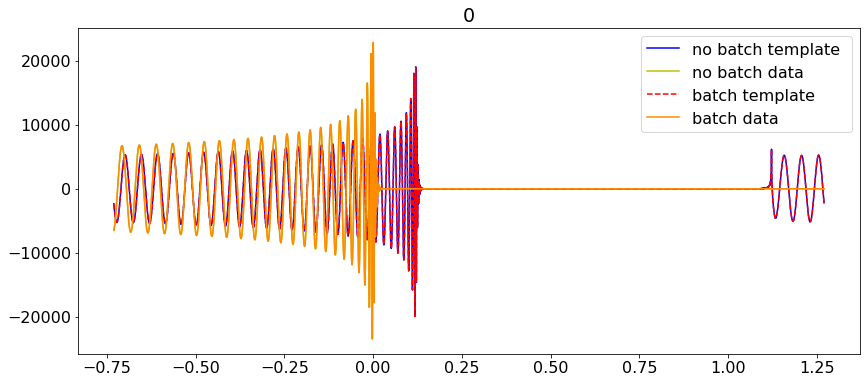

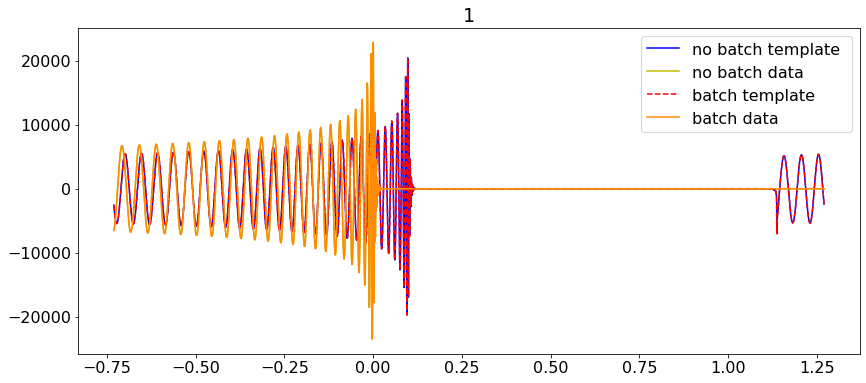

In [ ]:
for i in range(h1.data.shape[0]):
    plt.figure(figsize=(14, 6))
    plt.plot(
        h1_no_batchs[i].sample_times,
        h1_no_batchs[i].data,
        color="b",
        label="no batch template ",
    )
    plt.plot(
        h2_no_batchs[i].sample_times,
        h2_no_batchs[i].data,
        color="y",
        label="no batch data",
    )
    plt.plot(h1.sample_times[i], h1.data[i], color="r", linestyle = '--', label="batch template")

    plt.plot(h2.sample_times[0], h2.data[0], color="darkorange", label="batch data")

    plt.title(i)
    plt.legend()
    plt.show()
    plt.close()

In [30]:
match_batch = matchedfilter_batch.match(new_temp_batch_ts, new_sig_batch_ts)

<IPython.core.display.Javascript object>

In [35]:
matches_nobatch_loop = []
for i in range(new_temp_batch_ts.data.shape[0]):

    v1 = TimeSeries(new_temp_batch_ts.data[i], delta_t=new_temp_batch_ts.delta_t)
    v2 = TimeSeries(new_sig_batch_ts.data[0], delta_t=new_sig_batch_ts.delta_t)

    m = matchedfilter.match(v1, v2)
    matches_nobatch_loop.append(m)

<IPython.core.display.Javascript object>

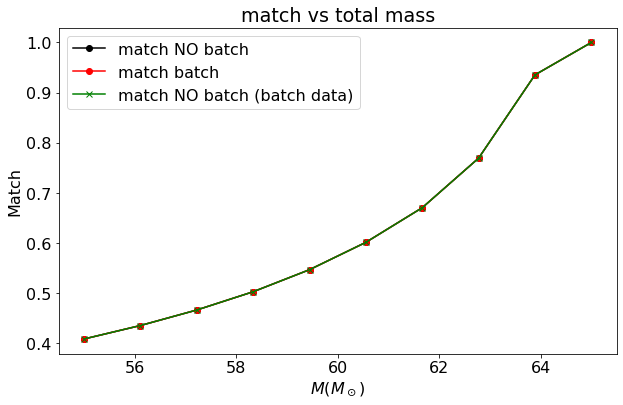

<IPython.core.display.Javascript object>

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(M_arr, matches_arr, "k-o", label="match NO batch")
plt.plot(M_arr, np.real(match_batch.numpy()), "r-o", label="match batch")
plt.plot(M_arr, matches_nobatch_loop, "g-x", label="match NO batch (batch data)")

plt.xlabel(r"$M (M_\odot)$")
plt.ylabel("Match")
plt.title("match vs total mass")
plt.legend()